In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import PercentFormatter
from matplotlib.container import BarContainer
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from dataclasses import dataclass
from scipy import stats
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.multitest import multipletests
from sklearn.manifold import TSNE
from itertools import combinations

#to output plots within the notebook
%matplotlib inline

In [2]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [3]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
outcome_col = "DEATH_EVENT"
assert outcome_col in df.columns, "Colonna DEATH_EVENT non trovata nel CSV"

num_features_all = df.select_dtypes(include=[np.number]).columns.tolist()

#exclude outcome column from numerical features, since it's a label not a feature
if outcome_col in num_features_all:
    num_features_all.remove(outcome_col)

### Binary and Continuous Features

In [173]:
#distinguish between binary and numeric features
binary_features = [c for c in num_features_all if set(pd.Series(df[c].dropna().unique()).astype(int)).issubset({0, 1})]
numeric_features = [c for c in num_features_all if c not in binary_features]
print(f"Binary features: {binary_features}")
print(f"Numeric features: {numeric_features}")

Binary features: ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
Numeric features: ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']


In [33]:
numeric_minMax_feature_values = zip(df[numeric_features], df[numeric_features].min(), df[numeric_features].mean(), df[numeric_features].max())
print(f'Numeric Minimum/Mean/Maximum values for each feature: {list(numeric_minMax_feature_values)}')

Numeric Minimum/Mean/Maximum values for each feature: [('age', 40.0, 60.83389297658862, 95.0), ('creatinine_phosphokinase', 23.0, 581.8394648829432, 7861.0), ('ejection_fraction', 14.0, 38.08361204013378, 80.0), ('platelets', 25100.0, 263358.02926421404, 850000.0), ('serum_creatinine', 0.5, 1.3938795986622072, 9.4), ('serum_sodium', 113.0, 136.62541806020067, 148.0), ('time', 4.0, 130.2608695652174, 285.0)]


In [6]:
@dataclass
class QuantileClipper:
    lower_q: float = 0.005
    upper_q: float = 0.995

    def fit(self, X, y=None):
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        self.lower_ = X.quantile(self.lower_q)
        self.upper_ = X.quantile(self.upper_q)
        return self

    def transform(self, X):
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X.copy()
        return X.clip(self.lower_, self.upper_, axis=1).values


### Feature Preprocessing

In [201]:
#preprocessing pipelines to remove missing values and scale the features
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  #substitute missing values with median
    ("clipper", QuantileClipper(lower_q=0.005, upper_q=0.995)),
    ("scaler", preprocessing.StandardScaler())
])

binary_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")) #substitute missing values with most frequent value
])

In [202]:
preprocess = ColumnTransformer( #apply different pipelines to different column sets
    transformers=[
        ("num", numeric_pipeline, numeric_features),
        ("bin", binary_pipeline, binary_features)
    ],
    remainder="drop", #drop other columns not specified in the transformers
    n_jobs=None
)

preprocess

,transformers,"[('num', ...), ('bin', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [205]:
#fit and transform the dataset
X = df[numeric_features + binary_features]
X_prep = preprocess.fit_transform(X)

# scaled_numeric_X = preprocessing.StandardScaler().fit_transform(df[numeric_features])
# X_prep = np.hstack((scaled_numeric_X, df[binary_features]))

X_prep

array([[ 1.19416318e+00,  7.13150611e-03, -1.54689900e+00, ...,
         1.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-4.91390866e-01,  6.75899860e+00, -3.18380503e-03, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 3.51386154e-01, -4.65527376e-01, -1.54689900e+00, ...,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       ...,
       [-1.33416789e+00,  1.60940175e+00,  1.88357921e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.33416789e+00,  1.99208200e+00, -3.18380503e-03, ...,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [-9.12779377e-01, -4.11323376e-01,  5.97149881e-01, ...,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00]],
      shape=(299, 12))

In [168]:
#combine preprocessed features into a DataFrame
prep_feature_names = numeric_features + binary_features
X_prep_df = pd.DataFrame(X_prep, columns=prep_feature_names, index=df.index)

#save preprocessed features to CSV
#X_prep_df.to_csv("preprocessed_features.csv", index=False)


In [206]:
X_prep_df.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time,anaemia,diabetes,high_blood_pressure,sex,smoking
0,1.194163,0.007132,-1.546899,0.024727,0.529596,-1.560050,-1.598465,0.0,0.0,1.0,1.0,0.0
1,-0.491391,6.758999,-0.003184,0.007177,-0.294142,-0.150764,-1.598465,0.0,0.0,0.0,1.0,0.0
2,0.351386,-0.465527,-1.546899,-1.076178,-0.088207,-1.794932,-1.591878,0.0,0.0,0.0,1.0,1.0
3,-0.912779,-0.503470,-1.546899,-0.563135,0.529596,0.084117,-1.591878,1.0,0.0,0.0,1.0,0.0
4,0.351386,-0.450350,-1.546899,0.687407,1.353334,-4.272927,-1.578962,1.0,1.0,0.0,0.0,0.0


### K-means Clustering

In [207]:
best_k = None
best_score = -1
best_labels = None

for k in range(2, 9):  #try with k from 3 to 4
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X_prep_df.values)
    #silhouette score is a measure of how similar a data point is to its own cluster compared to other clusters
    #the similarity is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample
    #the silhouette score ranges from -1 to +1, where a high value indicates that the data points are well clustered
    score = silhouette_score(X_prep_df.values, labels) #calculate silhouette score per k clusters
    print(f"Silhouette score for k={k}: {score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels
    
print(f"Best k found: {best_k} with silhouette score: {best_score:.4f}")
best_k = 3 #set best_k to 3 for better visualization

Silhouette score for k=2: 0.1117
Silhouette score for k=3: 0.0921
Silhouette score for k=4: 0.1030
Silhouette score for k=5: 0.1131
Silhouette score for k=6: 0.1134
Silhouette score for k=7: 0.1154
Silhouette score for k=8: 0.1271
Best k found: 8 with silhouette score: 0.1271


In [208]:
#use best k to fit final model
kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
cluster_labels = kmeans.fit_predict(X_prep_df.values)

#add cluster label to original df
df_with_clusters = df.copy()
df_with_clusters["cluster"] = cluster_labels
df_with_clusters.to_csv("data_with_clusters.csv", index=False)
df_with_clusters.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,cluster
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,2
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,0
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,0
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1,0
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1,2


### Plot t-SNE Clusting

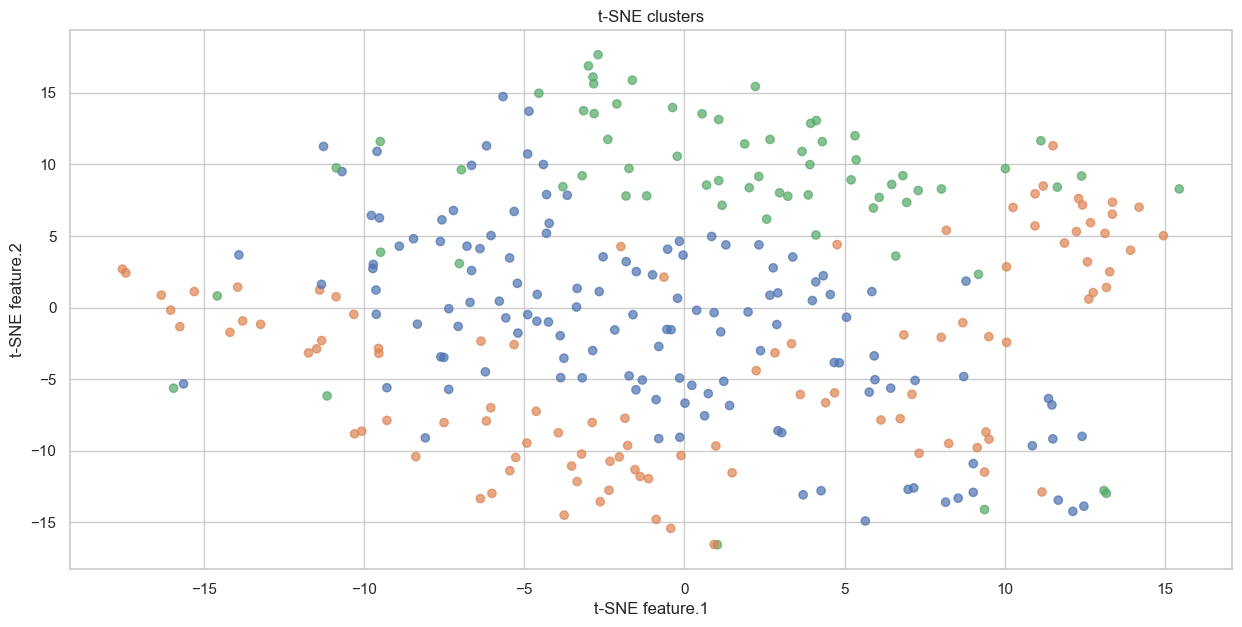

<Figure size 640x480 with 0 Axes>

In [219]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_prep_df)  #use tsne for dimentionality reduction on X_prep_df for visualization

palette = sns.color_palette('deep', n_colors=len(df_with_clusters['cluster'].unique()))
colors = [palette[label] for label in df_with_clusters['cluster']]

plt.figure(figsize=(15,7))
#scatter plot with t-SNE components colored by cluster labels
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.7)
plt.xlabel('t-SNE feature.1')
plt.ylabel('t-SNE feature.2')
plt.title('t-SNE clusters')
plt.show()
plt.clf()

In [62]:
#numeric statistics: mean, std, median per cluster
num_summary = df_with_clusters.groupby("cluster")[numeric_features].agg(["mean", "std", "median"])
num_summary.to_csv("cluster_summary_numeric.csv")

#binary statistics: count of 1s and proportions per cluster
bin_summary = None
if len(binary_features) > 0:
    bin_counts = df_with_clusters.groupby("cluster")[binary_features].sum(numeric_only=True)
    bin_sizes = df_with_clusters.groupby("cluster")[binary_features].count()
    bin_props = bin_counts / bin_sizes
    #unique counts and props with multi-index
    bin_summary = pd.concat(
        {"count_1": bin_counts, "prop_1": bin_props},
        axis=1
    )
    bin_summary.to_csv("cluster_summary_binary.csv")

In [68]:
print("Binary cluster summary:")
bin_summary.head()

Binary cluster summary:


count_1                                             prop_1            \
        anaemia diabetes high_blood_pressure sex smoking   anaemia  diabetes   
cluster                                                                        
0            55       58                  44  94      46  0.416667  0.439394   
1            44       38                  35  54      30  0.435644  0.376238   
2            30       29                  26  46      20  0.454545  0.439394   

                                                 
        high_blood_pressure       sex   smoking  
cluster                                          
0                  0.333333  0.712121  0.348485  
1                  0.346535  0.534653  0.297030  
2                  0.393939  0.696970  0.303030

In [ ]:
colors = cm.Dark2.colors[:3]

def plot_score_records(dataframe, model_name):
    #metric names
    metrics = ["count_1", "prop_1"]

    #select the feature names from one of the metrics
    feature_names = dataframe['count_1'].columns.tolist()
    x = range(len(feature_names))
    width = 0.20

    #plot scores
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"{model_name} Score per Cluster and Feature ({model_name})")

    for idx, metric in enumerate(metrics):
        #selecting all features under the top level 'metric'
        df_metric = dataframe[metric]

        #plot for Cluster 0, 1, and 2
        axs[idx].bar([i - width for i in x], df_metric.loc[0], width, label="Cluster 0", color=colors[0])
        axs[idx].bar([i for i in x], df_metric.loc[1], width, label="Cluster 1", color=colors[1])
        axs[idx].bar([i + width for i in x], df_metric.loc[2], width, label="Cluster 2", color=colors[2])

        axs[idx].set_xticks(x)
        axs[idx].set_xticklabels([x_item.capitalize() for x_item in feature_names], rotation=45, ha="right")
        axs[idx].set_ylabel(metric.capitalize().replace('_', ' '))
        axs[idx].set_title(f"{metric.capitalize().replace('_', ' ')}")
        axs[idx].legend(title="Cluster")

    plt.tight_layout()
    plt.show()
    plt.clf()
    #plt.savefig("cluster_summary_plot.png")

#plot_score_records(bin_summary, model_name="Clustering Model")

### Proportion of 1s Bar Plot

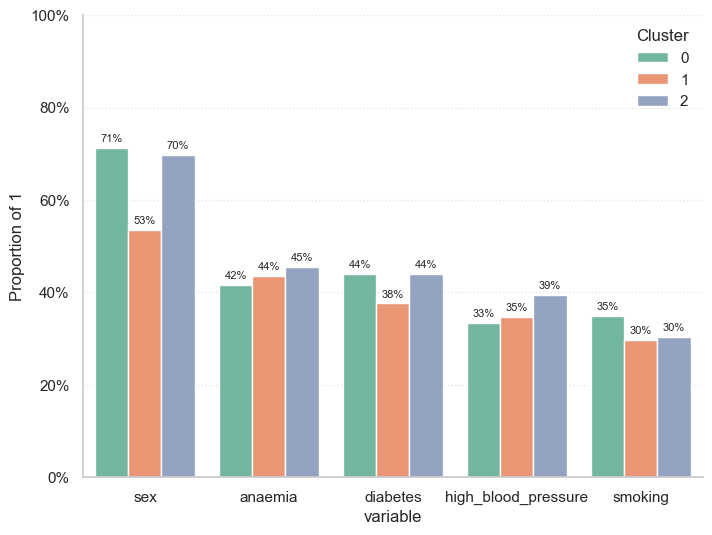

In [114]:
sns.set_theme(style="whitegrid")

counts_long = bin_summary['count_1'].reset_index().melt(id_vars='cluster', var_name='variable',
                                                        value_name='count_1')
props_long = bin_summary['prop_1'].reset_index().melt(id_vars='cluster', var_name='variable', value_name='prop_1')
long_df = props_long.merge(counts_long, on=['cluster', 'variable'])

n_per_cluster = df_with_clusters.groupby('cluster').size().rename('n')
long_df = long_df.merge(n_per_cluster, on='cluster')

var_order = long_df.groupby('variable')['prop_1'].mean().sort_values(ascending=False).index
clust_order = sorted(long_df['cluster'].unique())

fig, ax = plt.subplots(figsize=(min(16, max(8, 1.2 * len(var_order))), 6))
sns.barplot(
    data=long_df, x='variable', y='prop_1',
    order=var_order, hue='cluster', hue_order=clust_order,
    palette="Set2", errorbar=None, ax=ax
)

ax.set_ylim(0, 1)
ax.set_ylabel('Proportion of 1')
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

ax.grid(axis='y', linestyle=':', alpha=0.5)
ax.spines[['top', 'right']].set_visible(False)
plt.axhline(0, color='black', lw=0.8)

for t in list(ax.texts):
    t.remove()

bar_containers = [c for c in ax.containers if isinstance(c, BarContainer)]
for container in bar_containers:
    heights = [r.get_height() for r in container]
    labels = [f"{h:.0%}" if h > 0 else "" for h in heights]
    ax.bar_label(container, labels=labels, padding=3, fontsize=8)

if len(var_order) > 6:
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

ax.legend(title='Cluster', frameon=False)
plt.show()

### Count of 1s Bar Plot

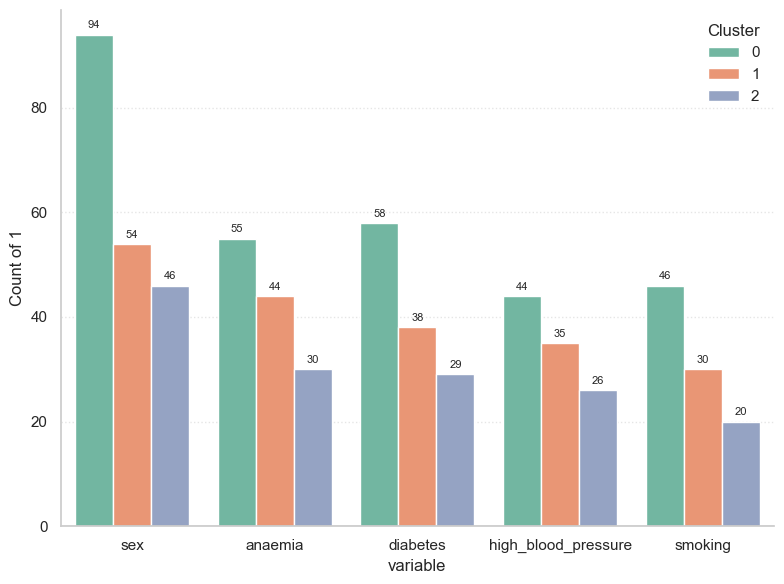

<Figure size 640x480 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize=(min(16, max(8, 1.2 * len(var_order))), 6))
sns.barplot(
    data=long_df, x='variable', y='count_1',
    order=var_order, hue='cluster', hue_order=clust_order,
    palette="Set2", errorbar=None, ax=ax 
)

ax.set_ylabel('Count of 1')
ax.grid(axis='y', linestyle=':', alpha=0.5)
ax.spines[['top', 'right']].set_visible(False)
plt.axhline(0, color='black', lw=0.8)

for t in list(ax.texts):
    t.remove()

bar_containers = [c for c in ax.containers if isinstance(c, BarContainer)]
for container in bar_containers:
    heights = [r.get_height() for r in container]
    labels = [f"{int(h)}" if h > 0 else "" for h in heights]
    ax.bar_label(container, labels=labels, padding=3, fontsize=8)

if len(var_order) > 6:
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

ax.legend(title='Cluster', frameon=False)
plt.tight_layout()
plt.show()
plt.clf()

#plt.savefig("binary_counts_grouped.png")

#### Binary clusters

In [119]:
print("Binary cluster summary:")
bin_summary.take(bin_summary.index)

Binary cluster summary:


count_1                                             prop_1            \
        anaemia diabetes high_blood_pressure sex smoking   anaemia  diabetes   
cluster                                                                        
0            55       58                  44  94      46  0.416667  0.439394   
1            44       38                  35  54      30  0.435644  0.376238   
2            30       29                  26  46      20  0.454545  0.439394   

                                                 
        high_blood_pressure       sex   smoking  
cluster                                          
0                  0.333333  0.712121  0.348485  
1                  0.346535  0.534653  0.297030  
2                  0.393939  0.696970  0.303030

#### Continuous clusters

In [120]:
print("Continuous cluster summary:")
num_summary.take(num_summary.index)

Continuous cluster summary:


age                   creatinine_phosphokinase               \
              mean        std median                     mean          std   
cluster                                                                      
0        57.148992   9.336997   58.0               641.893939  1131.202969   
1        57.491752  10.147425   58.0               501.346535   664.777985   
2        73.318182  10.552665   73.5               584.909091  1019.806629   

               ejection_fraction                        platelets  ...  \
        median              mean        std median           mean  ...   
cluster                                                            ...   
0        253.5         30.636364   7.392252   30.0  223916.395758  ...   
1        244.0         45.564356  10.984913   40.0  316816.893168  ...   
2        247.5         41.530303  11.606656   39.0  260433.034848  ...   

                    serum_creatinine                  serum_sodium            \
             median             mean       std median         mean       std   
cluster                                                                        
0        228000.000         1.245833  0.552649   1.10   135.803030  4.302386   
1        294000.000         1.045743  0.302792   1.00   139.118812  2.980896   
2        262679.015         2.222727  1.794303   1.75   134.454545  4.739951   

                      time                    
        median        mean        std median  
cluster                                       
0        136.0  132.303030  73.381981  120.0  
1        139.0  169.415842  69.534634  187.0  
2        134.0   66.257576  52.689602   47.5  

[3 rows x 21 columns]

### Box Plot per Each Continuous Feature

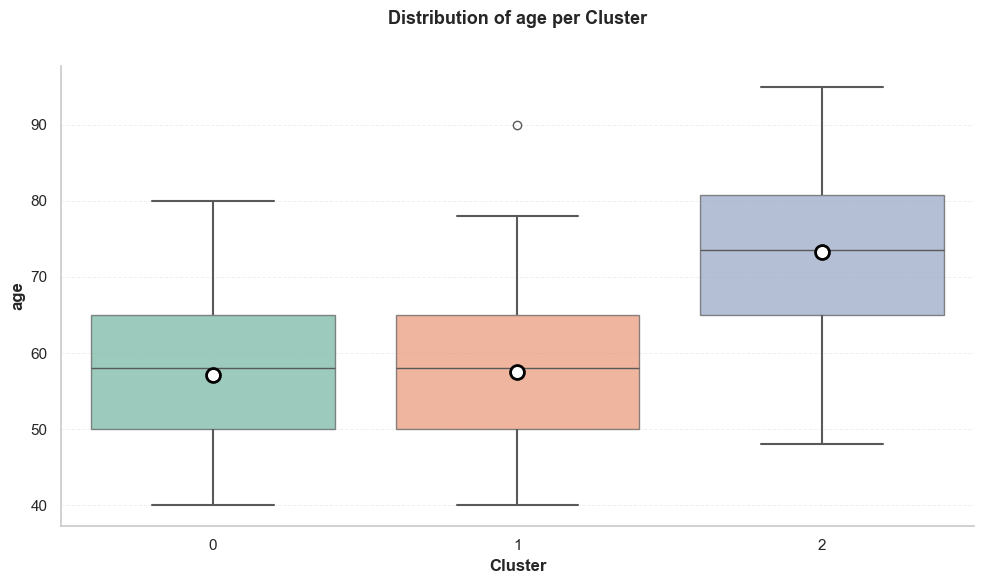

<Figure size 640x480 with 0 Axes>

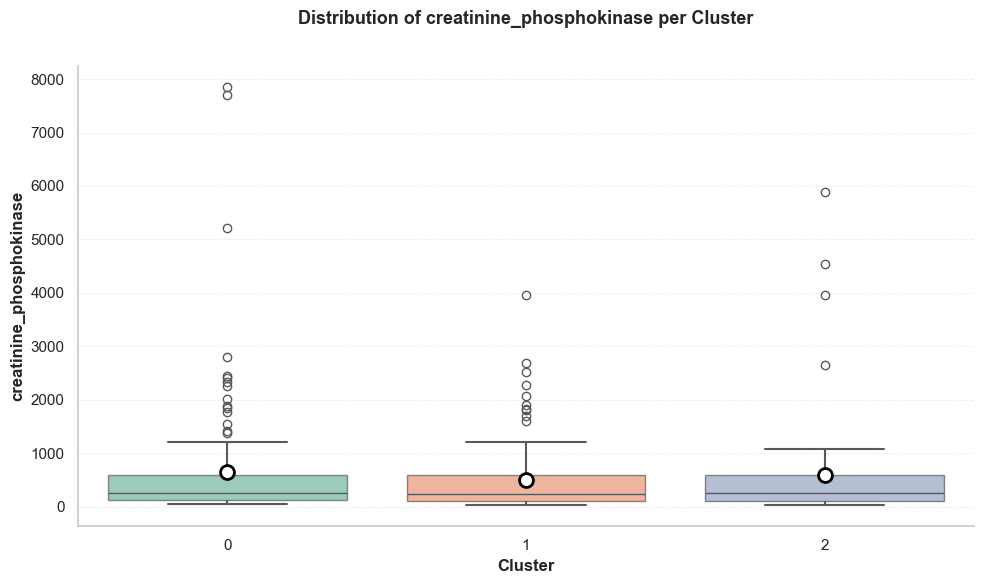

<Figure size 640x480 with 0 Axes>

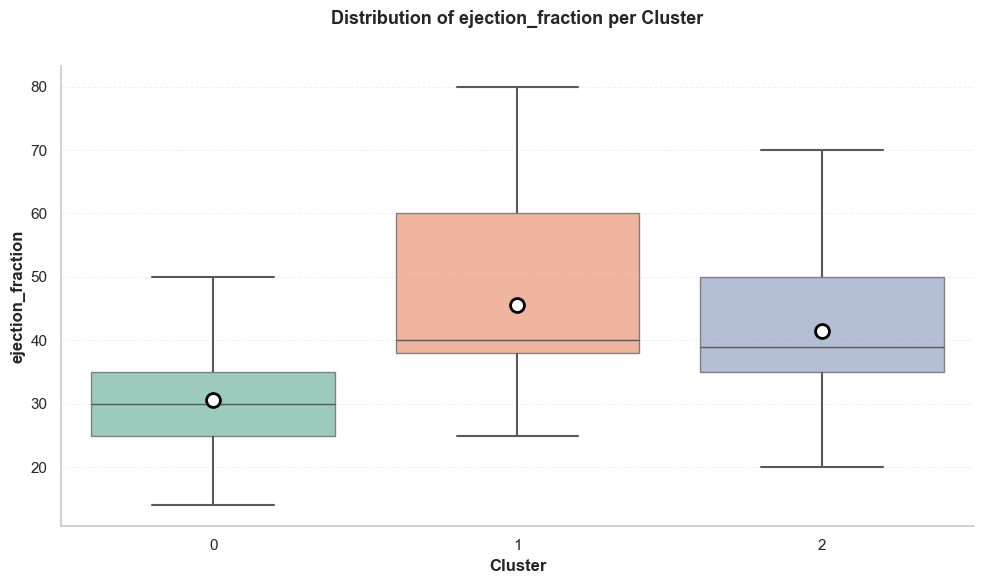

<Figure size 640x480 with 0 Axes>

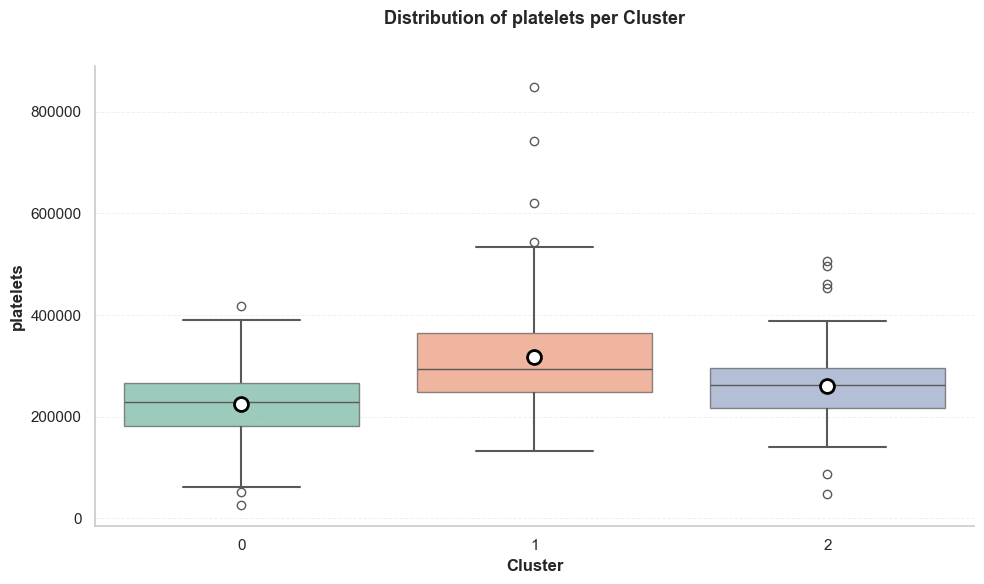

<Figure size 640x480 with 0 Axes>

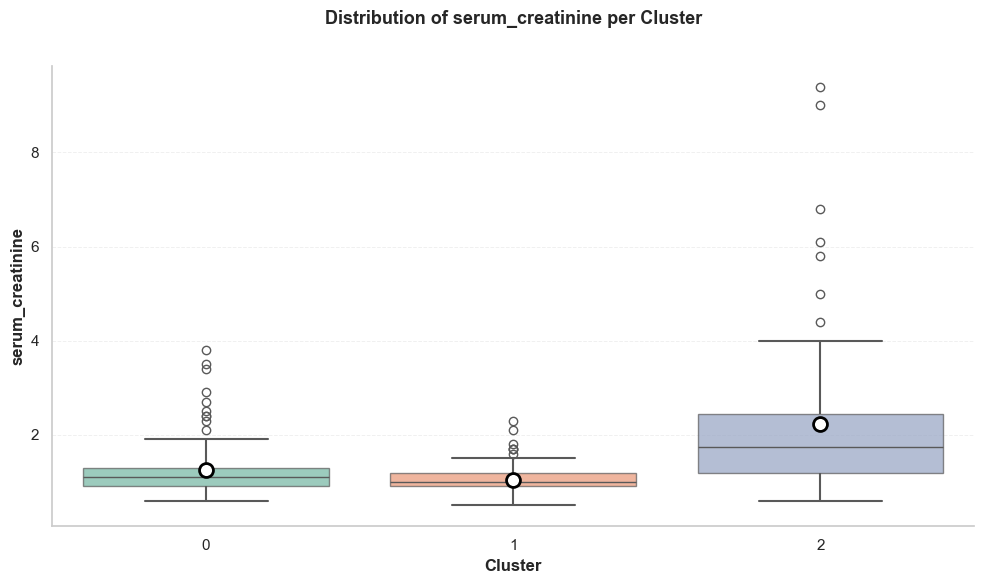

<Figure size 640x480 with 0 Axes>

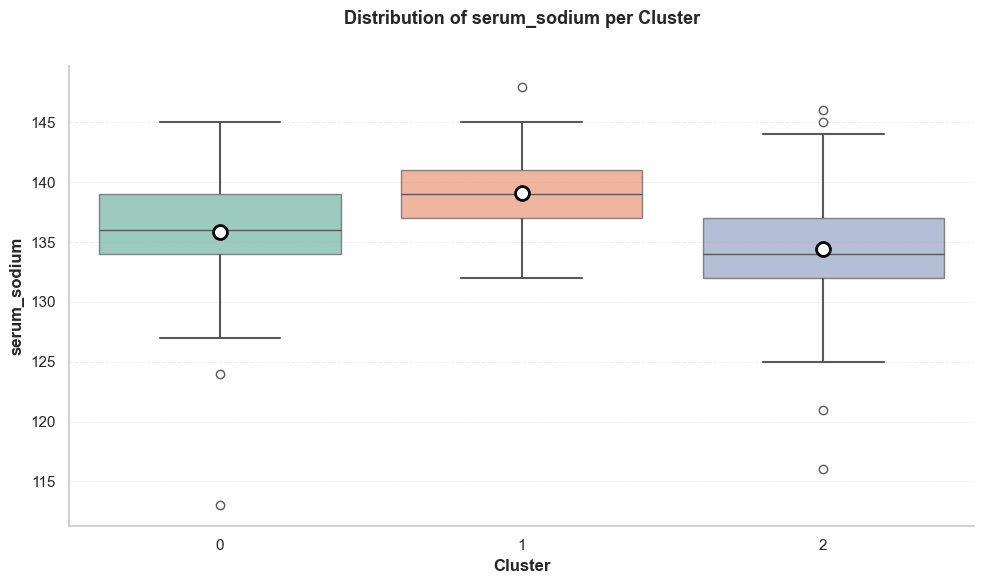

<Figure size 640x480 with 0 Axes>

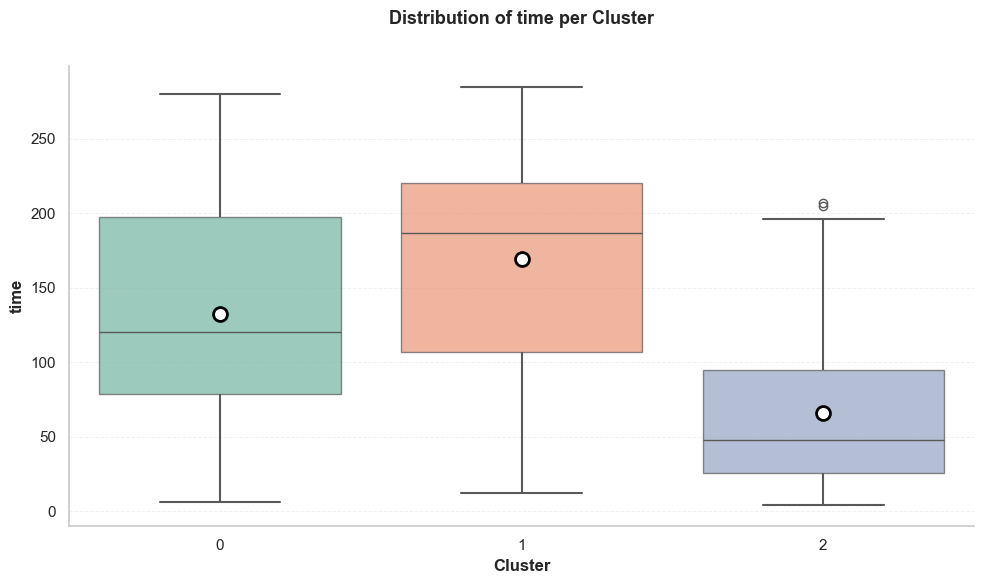

<Figure size 640x480 with 0 Axes>

In [113]:
for var in numeric_features:
    plt.figure(figsize=(10, 6))

    ax = sns.boxplot(
        data=df_with_clusters,
        x='cluster',
        y=var,
        hue='cluster',
        palette='Set2',
        legend=False,
        showmeans=True,
        meanprops={
            "marker": "o",
            "markerfacecolor": "white",
            "markeredgecolor": "black",
            "markeredgewidth": 2,
            "markersize": 10
        },
        boxprops=dict(alpha=0.7),
        whiskerprops=dict(linewidth=1.5),
        capprops=dict(linewidth=1.5)
    )

    cluster_stats = df_with_clusters.groupby('cluster')[var].agg(['mean', 'median'])

    plt.title(
        f'Distribution of {var} per Cluster\n',
        fontsize=13,
        fontweight='bold',
        pad=15
    )
    plt.xlabel('Cluster', fontsize=12, fontweight='bold')
    plt.ylabel(f'{var}', fontsize=12, fontweight='bold')

    plt.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.7)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    #save the plot
    filename = f'boxplot_{var}_clusters.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.clf()

In [ ]:
#outcome death_rate per cluster
outcome_rate = df_with_clusters.groupby("cluster")[outcome_col].mean()
#outcome_rate.to_csv("cluster_outcome_rate.csv")

outcome_rate.head()

cluster
0    0.333333
1    0.089109
2    0.651515
Name: DEATH_EVENT, dtype: float64

### Tests
* We'll use Kruskal-wallis for continuous variabiles' test because it doesn't require any assumptions to be validated before applying the test. Meanwhile Anova has various assumptions and requires that the variance of the continuous variable is roughly equal across all groups/clusters. Kruskal-Wallis tells us if a difference exists (p-value) between clusters, p-value measures the diversity of at least one group w.r.t. the other groups.
    - A large p-value means that there's no significant difference in distribution across the groups.
    - A small p-value means that at least one group's distribution is significantly different from the others.
Cohen's d is primarily calculated for each two groups, but when used in the context of Kruskal-Wallis, it is applied to the pairwise comparisons to quantify the size of the difference between each specific pair of groups. Cohen's d measures the effect size of the separability between groups.(larger cohen's d absolute value indicates a major separability between a pair of groups).

* We'll use Chi-square for binary variabiles' test because we have at least 5 values in the contingency table before applying the test across all groups/clusters. Meanwhile Fisher has the condition that we have less 5 values in the contingency table. Chi-square tells us if there is a significant relationship between two categorical variables, p-value measures the diversity of at least one group w.r.t. the other groups.
    - A large p-value means that there's no significant difference in distribution across the groups.
    - A small p-value means that at least one group's distribution is significantly different from the others.
The Proportion difference (known as the Risk difference) is a straightforward measure of effect size for binary values. It quantifies the absolute difference between the proportions of a value occurring between two groups.
(larger proportion-diff absolute value indicates a major separability between a pair of groups).

In [155]:
#test for continuous variables: Kruskal-Wallis + Cohen's d
continuous_test_results = []

for var in numeric_features:
    groups = [df_with_clusters[df_with_clusters['cluster'] == c][var].dropna()
              for c in sorted(df_with_clusters['cluster'].unique())]

    test_name = "Kruskal-Wallis"
    stat, p_value = stats.kruskal(*groups)

    #Cohen's d for each pair of clusters
    cohens_d_pairs = {}
    if len(groups) >= 2:
        for i, j in combinations(range(len(groups)), 2):
            if len(groups[i]) > 0 and len(groups[j]) > 0:
                mean_diff = groups[i].mean() - groups[j].mean()
                pooled_std = np.sqrt((groups[i].std() ** 2 + groups[j].std() ** 2) / 2)
                cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0

                #cluster effective labels
                cluster_labels = sorted(df_with_clusters['cluster'].unique())
                cohens_d_pairs[f'Cohen\'s d{cluster_labels[i]}_vs_{cluster_labels[j]}'] = cohens_d
            else:
                cluster_labels = sorted(df_with_clusters['cluster'].unique())
                cohens_d_pairs[f'Cohen\'s d{cluster_labels[i]}_vs_{cluster_labels[j]}'] = np.nan
    else:
        cohens_d_pairs = {}

    continuous_test_results.append({
        'variable': var,
        'test': test_name,
        'statistic': stat,
        'p_value': p_value,
        **cohens_d_pairs
    })

continuous_results_df = pd.DataFrame(continuous_test_results)

#Benjamini-Hochberg correction
if len(continuous_results_df) > 0:
    reject, p_adj, _, _ = multipletests(
        continuous_results_df['p_value'],
        method='fdr_bh',
        alpha=0.05
    )
    continuous_results_df['p_adjusted'] = p_adj
    continuous_results_df['significant'] = reject

continuous_results_df.to_csv('cluster_tests_continuous.csv', index=False)

#test for binary variables: Chi-square + proportion difference
if len(binary_features) > 0:
    binary_test_results = []

    for var in binary_features:
        #contingency table{ cluster: value (0/1) }
        contingency = pd.crosstab(
            df_with_clusters['cluster'],
            df_with_clusters[var]
        )

        #print(f"Contingency table for variable {var}:\n{contingency}\n")

        test_name = "Chi-square"
        stat, p_value, _, _ = chi2_contingency(contingency)

        #proportion difference between cluster 0 and 1
        prop_diffs = {}
        props = df_with_clusters.groupby('cluster')[var].mean()

        if len(props) >= 2:
            cluster_labels = sorted(df_with_clusters['cluster'].unique())

            for i, j in combinations(range(len(cluster_labels)), 2):
                cluster_i = cluster_labels[i]
                cluster_j = cluster_labels[j]
                prop_diff = props.iloc[i] - props.iloc[j]
                prop_diffs[f'prop_diff_{cluster_i}_vs_{cluster_j}'] = prop_diff

        binary_test_results.append({
            'variable': var,
            'test': test_name,
            'statistic': stat,
            'p_value': p_value,
            **prop_diffs
        })

    binary_results_df = pd.DataFrame(binary_test_results)

    #Benjamini-Hochberg correction
    if len(binary_results_df) > 0:
        reject, p_adj, _, _ = multipletests(
            binary_results_df['p_value'],
            method='fdr_bh',
            alpha=0.05
        )
        binary_results_df['p_adjusted'] = p_adj
        binary_results_df['significant'] = reject

    binary_results_df.to_csv('cluster_tests_binary.csv', index=False)

print(f"\nStatistical tests completed: {len(continuous_results_df)} continuous, {len(binary_results_df) if len(binary_features) > 0 else 0} binary")


Statistical tests completed: 7 continuous, 5 binary


In [116]:
print("Continuous cluster results:")
continuous_results_df.take(continuous_results_df.index)

Continuous cluster results:


,variable,test,statistic,p_value,Cohen's d0_vs_1,Cohen's d0_vs_2,Cohen's d1_vs_2,p_adjusted,significant
0,age,Kruskal-Wallis,80.651205,3.067703e-18,-0.035153,-1.622860,-1.528824,1.073696e-17,True
1,creatinine_phosphokinase,Kruskal-Wallis,0.853148,6.527416e-01,0.151488,0.052913,-0.097076,6.527416e-01,False
2,ejection_fraction,Kruskal-Wallis,104.013081,2.593262e-23,-1.594441,-1.119582,0.356994,1.815283e-22,True
3,platelets,Kruskal-Wallis,51.243965,7.456144e-12,-0.996798,-0.470978,0.566315,8.698835e-12,True
4,serum_creatinine,Kruskal-Wallis,55.955814,7.068860e-13,0.449045,-0.735845,-0.914730,9.896404e-13,True
5,serum_sodium,Kruskal-Wallis,66.478287,3.667950e-15,-0.895891,0.297912,1.178039,6.418913e-15,True
6,time,Kruskal-Wallis,71.293668,3.301998e-16,-0.519175,1.033911,1.672210,7.704662e-16,True


In [117]:
print("Binary cluster results:")
binary_results_df.take(binary_results_df.index)

Binary cluster results:


,variable,test,statistic,p_value,prop_diff_0_vs_1,prop_diff_0_vs_2,prop_diff_1_vs_2,p_adjusted,significant
0,anaemia,Chi-square,0.268361,0.874432,-0.018977,-0.037879,-0.018902,0.874432,False
1,diabetes,Chi-square,1.096559,0.577943,0.063156,0.000000,-0.063156,0.870485,False
2,high_blood_pressure,Chi-square,0.723696,0.696388,-0.013201,-0.060606,-0.047405,0.870485,False
3,sex,Chi-square,8.770591,0.012459,0.177468,0.015152,-0.162316,0.062296,False
4,smoking,Chi-square,0.821425,0.663177,0.051455,0.045455,-0.006001,0.870485,False
